In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

This notebook isolates temporary mortality shocks rather than long-term structural trends.

Convergence warnings may arise due to the parsimonious random walk specification and limited sample size.

In [2]:
df = pd.read_csv('adult_mortality_indonesia.csv')
train_pre_covid = df[df['year'] <= 2019].copy()
actual_covid_era = df[df['year'] >= 2020].copy()
df.head()

,year,female,male
0,1990,185.624,234.896
1,1991,183.488,229.230
2,1992,179.502,224.371
3,1993,170.382,216.580
4,1994,174.249,215.981


In [3]:
shocks_results = {}

for gender in ['male', 'female']:
    model = ARIMA(np.log(train_pre_covid[gender]), order=(0, 1, 0), trend='t').fit()

    fc_obj = model.get_forecast(steps=len(actual_covid_era))
    counterfactual = np.exp(fc_obj.predicted_mean).values

    actual = actual_covid_era[gender].values

    shock_abs = actual - counterfactual
    shock_pct = (shock_abs / counterfactual) * 100
    
    shocks_results[gender] = {
        'years': actual_covid_era['year'].values,
        'actual': actual,
        'counterfactual': counterfactual,
        'shock_abs': shock_abs,
        'shock_pct': shock_pct
    }

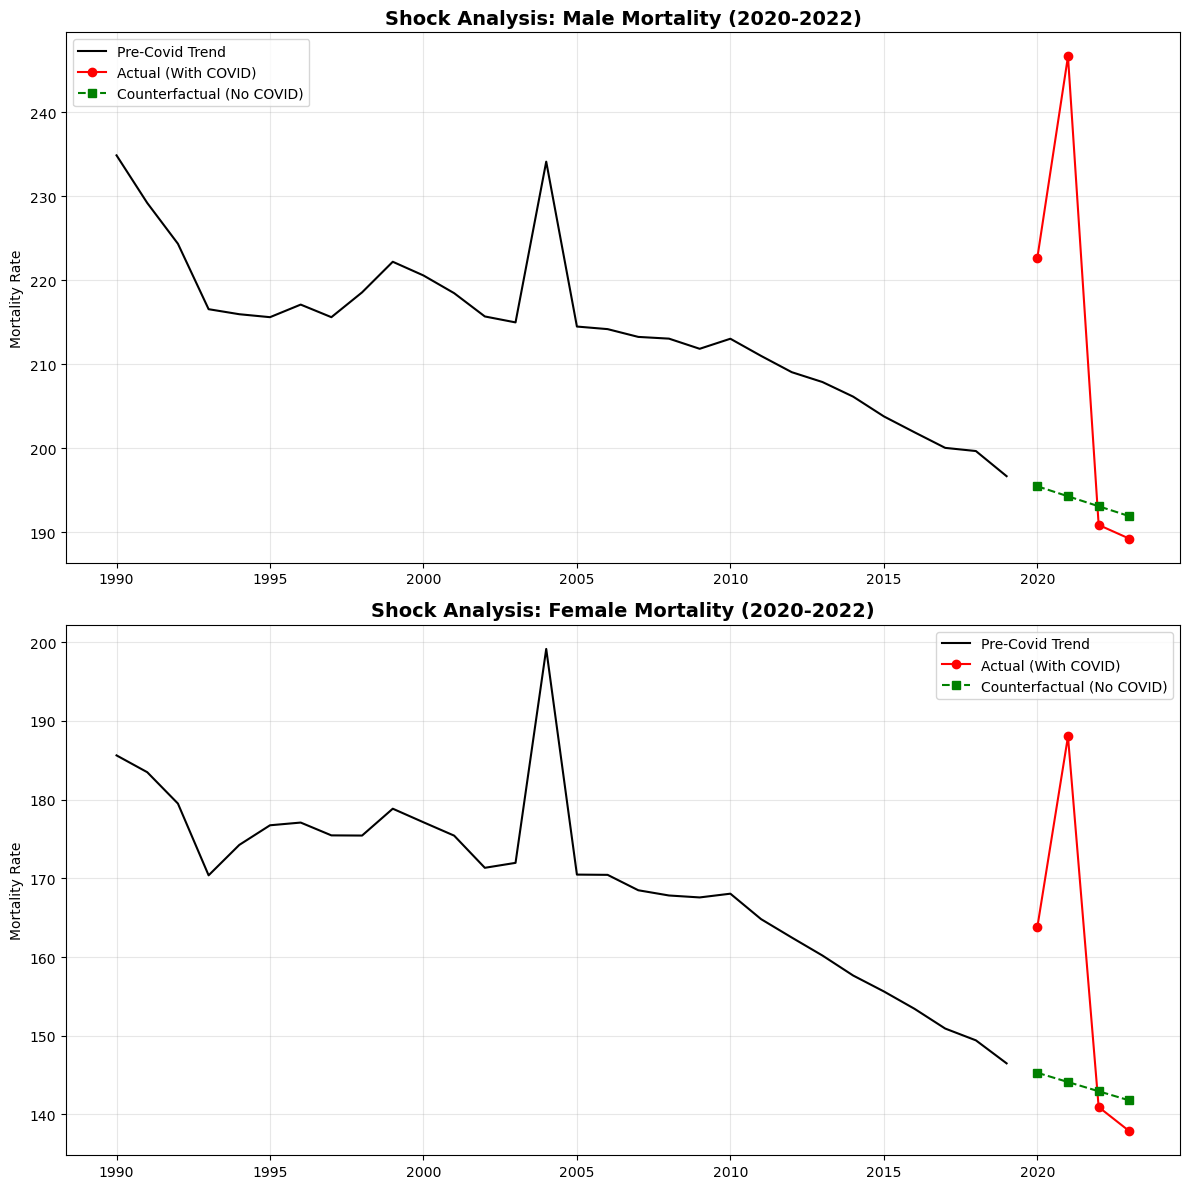

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(12, 12))

for i, gender in enumerate(['male', 'female']):
    res = shocks_results[gender]
    
    # Plot Data Historis
    ax[i].plot(train_pre_covid['year'], train_pre_covid[gender], color='black', label='Pre-Covid Trend')
    
    # Plot Realitas (2020-2022)
    ax[i].plot(res['years'], res['actual'], color='red', marker='o', label='Actual (With COVID)')
    
    # Plot Counterfactual (Skenario Tanpa COVID)
    ax[i].plot(res['years'], res['counterfactual'], color='green', linestyle='--', marker='s', label='Counterfactual (No COVID)')
    
    ax[i].set_title(f'Shock Analysis: {gender.capitalize()} Mortality (2020-2022)', fontsize=14, fontweight='bold')
    ax[i].set_ylabel('Mortality Rate')
    ax[i].legend()
    ax[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

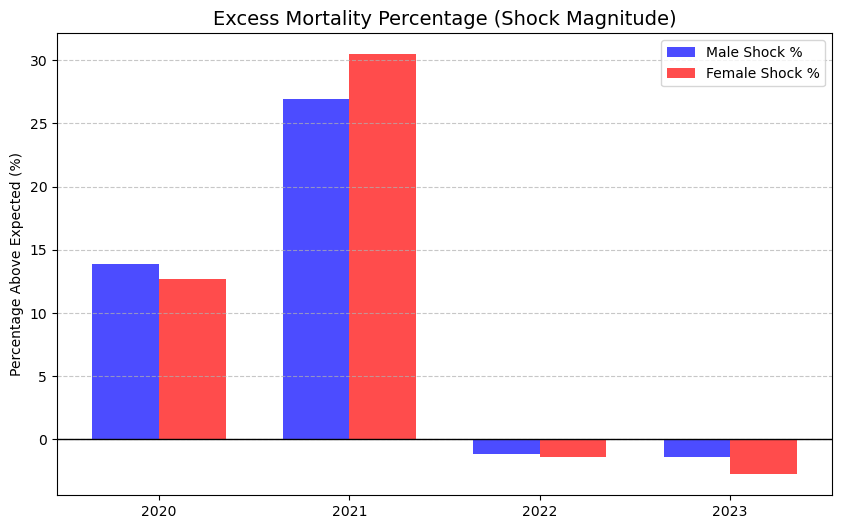


--- Summary Shock MALE ---
Year 2020: 13.89% excess mortality
Year 2021: 26.95% excess mortality
Year 2022: -1.15% excess mortality
Year 2023: -1.40% excess mortality

--- Summary Shock FEMALE ---
Year 2020: 12.71% excess mortality
Year 2021: 30.47% excess mortality
Year 2022: -1.40% excess mortality
Year 2023: -2.76% excess mortality


In [5]:
plt.figure(figsize=(10, 6))
x = np.arange(len(actual_covid_era['year']))
width = 0.35

plt.bar(x - width/2, shocks_results['male']['shock_pct'], width, label='Male Shock %', color='blue', alpha=0.7)
plt.bar(x + width/2, shocks_results['female']['shock_pct'], width, label='Female Shock %', color='red', alpha=0.7)

plt.xticks(x, actual_covid_era['year'])
plt.axhline(0, color='black', linewidth=1)
plt.title('Excess Mortality Percentage (Shock Magnitude)', fontsize=14)
plt.ylabel('Percentage Above Expected (%)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Print Tabel Ringkasan Shock
for gender in ['male', 'female']:
    print(f"\n--- Summary Shock {gender.upper()} ---")
    for yr, s_pct in zip(shocks_results[gender]['years'], shocks_results[gender]['shock_pct']):
        print(f"Year {yr}: {s_pct:.2f}% excess mortality")